In [1]:
#James Alfano
import pandas as pd
import datasets
import warnings
import sys
import numpy as np
from Preprocessing import *
from transformers import pipeline
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
import transformers
import torch
from huggingface_hub import notebook_login
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import gc
#! pip install datasets transformers rouge-score nltk

In [2]:
#Run these commands when running for first time
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

## Reading in the Data

In [3]:
## load the full dataset of 300k articles
dataset = datasets.load_dataset("cnn_dailymail", '3.0.0')

Found cached dataset cnn_dailymail (C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [5]:
#Read in Training
lst_dics = [dic for dic in dataset["train"]]
train = pd.DataFrame(lst_dics).rename(columns={"article":"text", 
      "highlights":"y","id":"id"})[["text","y","id"]]
train.head()

,text,y,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


In [6]:
#Read in testing
lst_dics = [dic for dic in dataset["test"]]
test = pd.DataFrame(lst_dics).rename(columns={"article":"text", 
      "highlights":"y","id":"id"})[["text","y","id"]]
test.head()

,text,y,id
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef
2,"(CNN)If you've been following the news lately,...",Mohammad Javad Zarif has spent more time with ...,4495ba8f3a340d97a9df1476f8a35502bcce1f69
3,(CNN)Five Americans who were monitored for thr...,17 Americans were exposed to the Ebola virus w...,a38e72fed88684ec8d60dd5856282e999dc8c0ca
4,(CNN)A Duke student has admitted to hanging a ...,Student is no longer on Duke University campus...,c27cf1b136cc270023de959e7ab24638021bc43f


In [7]:
#Read in Validation
lst_dics = [dic for dic in dataset["validation"]]
validation = pd.DataFrame(lst_dics).rename(columns={"article":"text", 
      "highlights":"y","id":"id"})[["text","y","id"]]
validation.head()

,text,y,id
0,"(CNN)Share, and your gift will be multiplied. ...",Zully Broussard decided to give a kidney to a ...,a4942dd663020ca54575471657a0af38d82897d6
1,"(CNN)On the 6th of April 1996, San Jose Clash ...",The 20th MLS season begins this weekend .\nLea...,4157bc4da185971e2742f349d69a037343bc0d95
2,"(CNN)French striker Bafetimbi Gomis, who has a...",Bafetimbi Gomis collapses within 10 minutes of...,60736693e3b1b32d14337a317190c6606e879a85
3,(CNN)It was an act of frustration perhaps more...,Rory McIlroy throws club into water at WGC Cad...,8cdf9cc3ed0276b7a7944cc18ba459355b5984ad
4,(CNN)A Pennsylvania community is pulling toget...,"Cayman Naib, 13, hasn't been heard from since ...",2e6613d531843515bf5401286cc3e45c4df530d2


In [8]:
print(train.shape)
print(test.shape)
print(validation.shape)


(287113, 3)
(11490, 3)
(13368, 3)


In [9]:
print(train.iloc[0,0])

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details of how

In [10]:
print(train.iloc[0,1])

Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .


## Preprocessing 

In [11]:
#take a subset of the training data
subset_train = train.iloc[0:15000,0:15000]
subset_test = test.iloc[0:10000,0:10000]
subset_valid = validation.iloc[0:10000,0:10000]


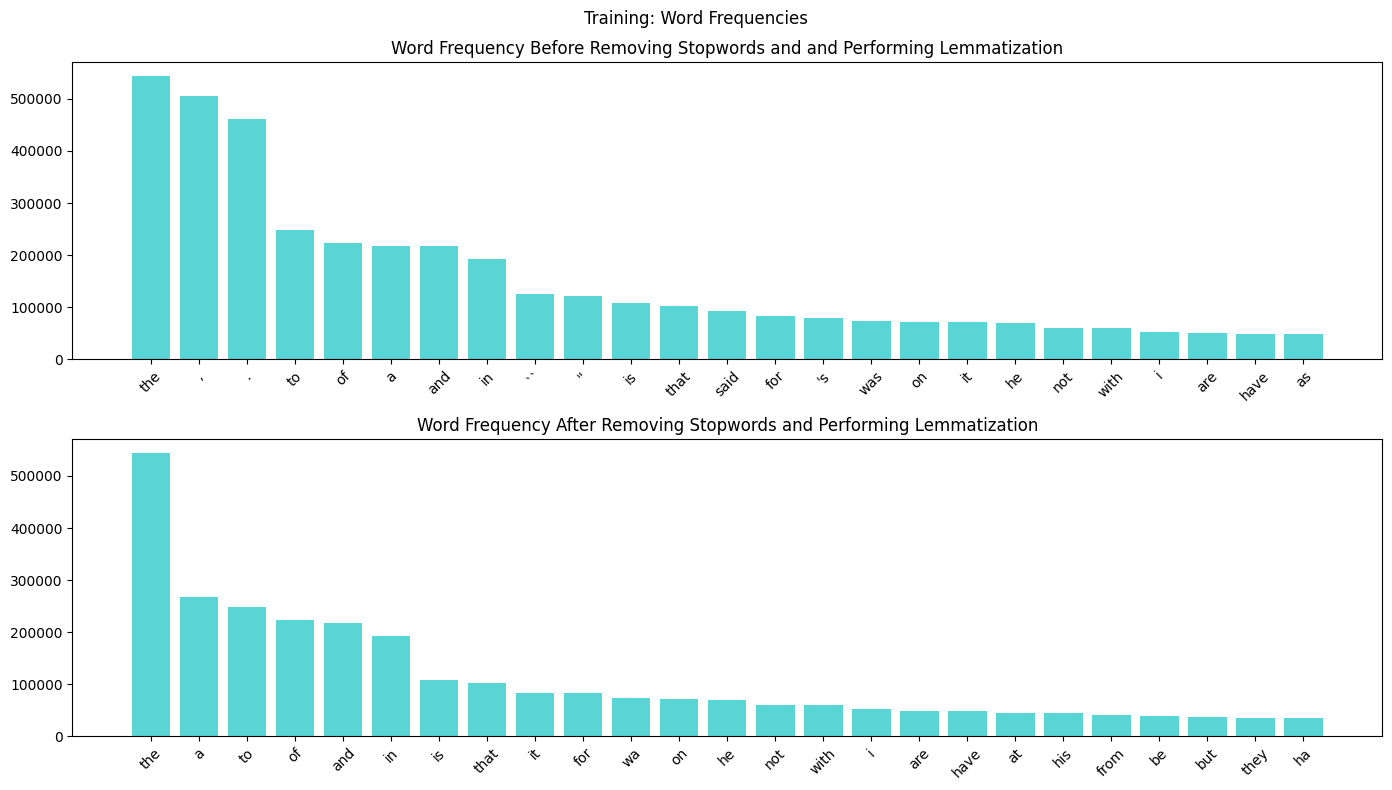

In [12]:
preprocess(subset_train,"Training",1)

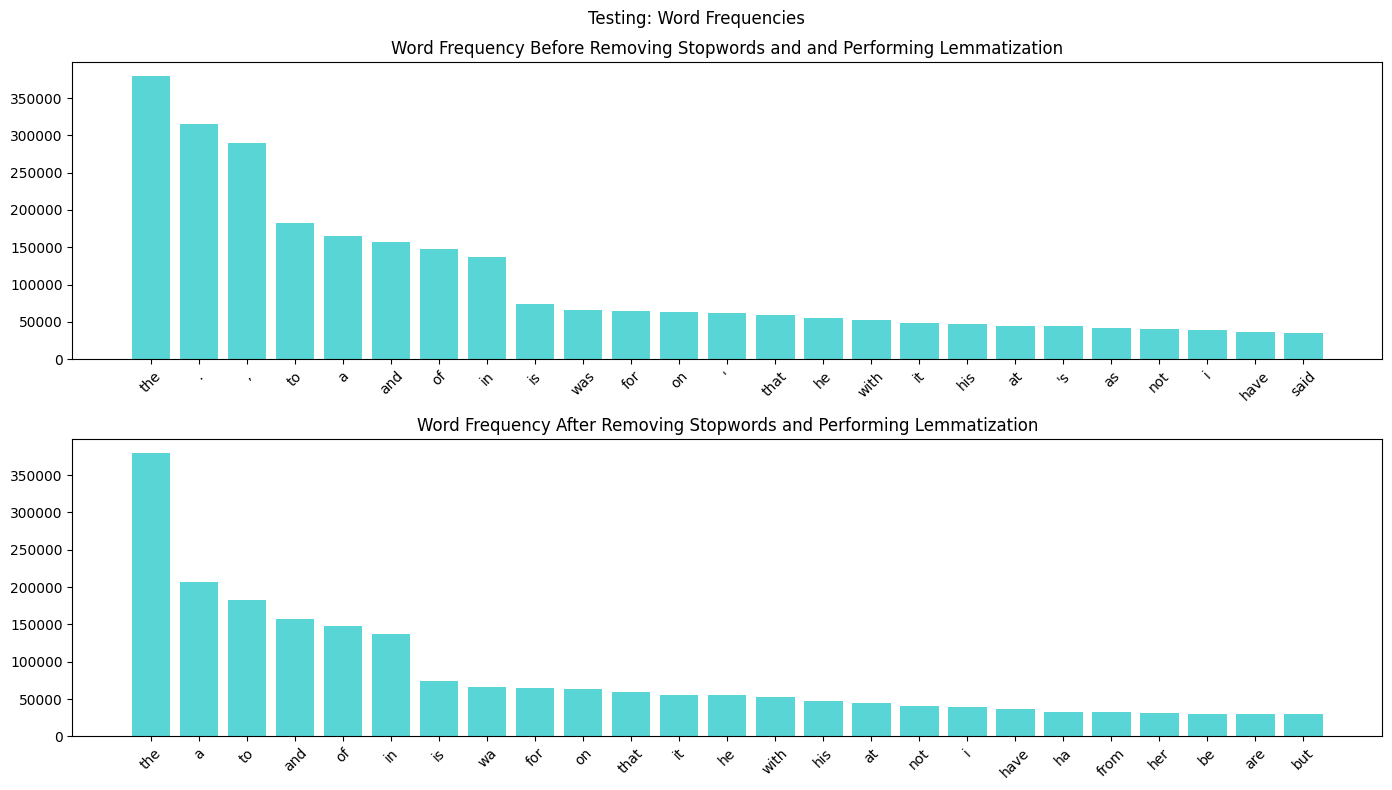

In [13]:
preprocess(subset_test,"Testing",1)

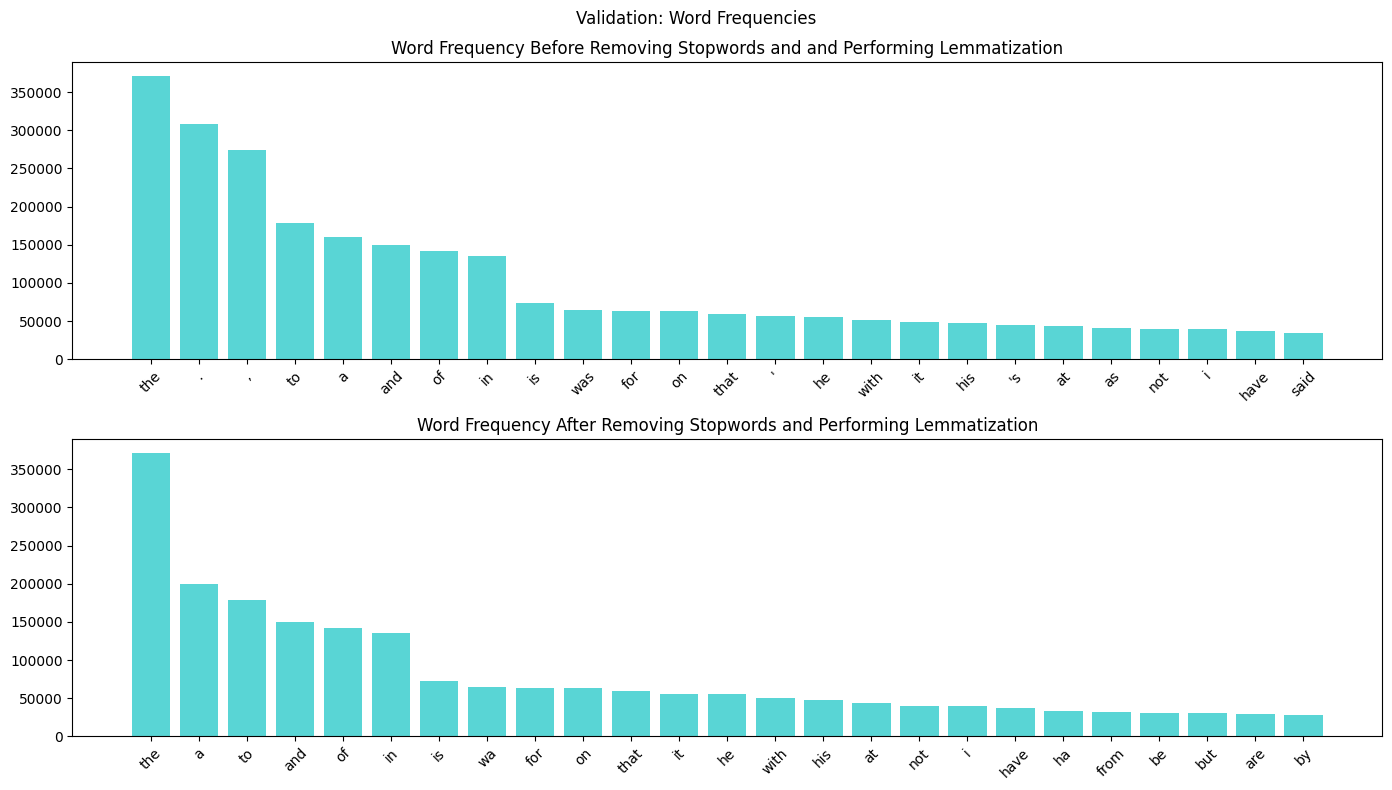

In [14]:
preprocess(subset_valid,"Validation",1)

In [15]:
#Run Function to get the average word count and list of counts for all articles and summaries 
avg_y, lenghts_y = avg_num_words(subset_train["y"])
avg_text, lenghts_text = avg_num_words(subset_train["text"])

The longest summary has 90 words
The longest article has 1850 words


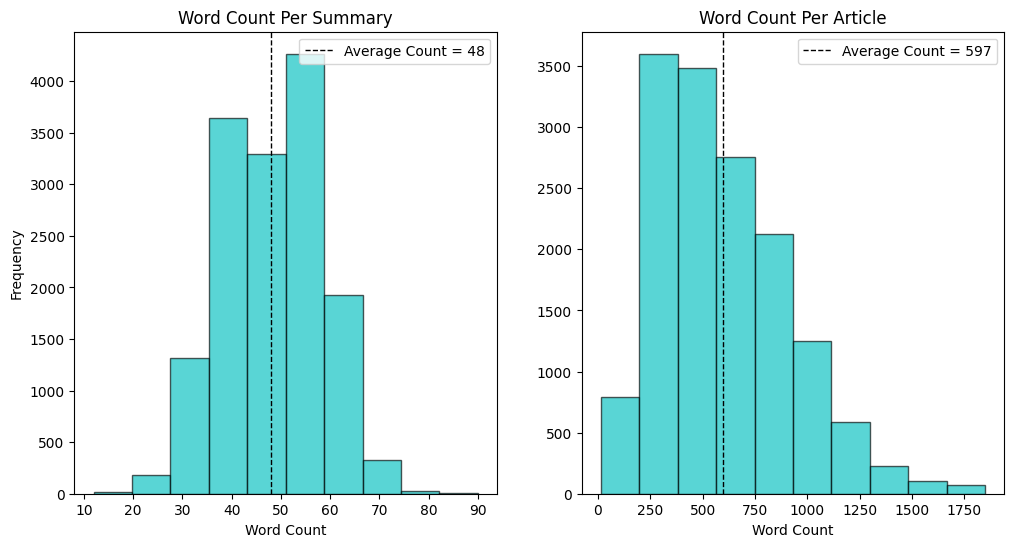

In [16]:
plot_counts(subset_train)

In [17]:
dataset = combine_data(subset_train,subset_test,subset_valid)

In [18]:
#d = {'train':Dataset.from_dict({"article":subset_train["text"],"highlights":subset_train["y"],"id":subset_train["id"]}),
#        'validation':Dataset.from_dict({"article":subset_valid["text"],"highlights":subset_valid["y"],"id":subset_valid["id"]}),
#        'test':Dataset.from_dict({"article":subset_test["text"],"highlights":subset_test["y"],"id":subset_test["id"]})
#        }
#dataset = DatasetDict(d)
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 10000
    })
})

## Building the Model

In [19]:
#warnings.filterwarnings("ignore")
metric = load_metric("rouge")
model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

C:\Users\James\AppData\Local\Temp\ipykernel_10452\3971605420.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")
c:\Users\James\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\t5\tokenization_t5_fast.py:156: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantia

In [20]:
#Get max lenght for texts and summaries 
max_input_length = max(lenghts_text)
max_target_length = max(lenghts_y)
#max_input_length = 1000
#ax_target_length = 90

def prepare_for_model(examples):
    #T5 models requires summaries of text lead with "summarize: "
    prefix = "summarize: "
    inputs = [prefix + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["highlights"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [21]:
tokenized_datasets = dataset.map(prepare_for_model, batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

c:\Users\James\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:3546: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [22]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
})

In [23]:
#The model used below requires significant computing power
#More then my local machine can handle
#This is an attempt to free up processing power

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Making space on the gpu
torch.cuda.empty_cache()
gpu_usage()

Using device: cuda
| ID | GPU | MEM |
------------------
|  0 | 12% | 10% |


In [24]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [25]:
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-cnn-articles5",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    auto_find_batch_size = True, #automated to find a batch size that will fit into memory automatically, avoiding CUDA Out-of-Memory errors
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
)

In [26]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [27]:
import nltk
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [28]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


Using cuda_amp half precision backend


## Training

In [29]:
trainer.train()
trainer.save_model()

c:\Users\James\AppData\Local\Programs\Python\Python39\lib\site-packages\accelerate\memory_utils.py:23: FutureWarning: memory_utils has been reorganized to utils.memory. Import `find_executable_batchsize` from the main `__init__`: `from accelerate import find_executable_batch_size` to avoid this warning.
  warnings.warn(
The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: article, id, highlights. If article, id, highlights are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
c:\Users\James\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 150

  0%|          | 0/1875 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: article, id, highlights. If article, id, highlights are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 15000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3750
  Number of trainable parameters = 60506624


  0%|          | 0/3750 [00:00<?, ?it/s]

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: article, id, highlights. If article, id, highlights are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 15000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7500
  Number of trainable parameters = 60506624


  0%|          | 0/7500 [00:00<?, ?it/s]

Saving model checkpoint to t5-small-finetuned-cnn-articles5\checkpoint-500
Configuration saved in t5-small-finetuned-cnn-articles5\checkpoint-500\config.json


{'loss': 2.8332, 'learning_rate': 1.4656000000000002e-05, 'epoch': 0.07}


Model weights saved in t5-small-finetuned-cnn-articles5\checkpoint-500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles5\checkpoint-500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles5\checkpoint-500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles5\checkpoint-6500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles5\checkpoint-1000
Configuration saved in t5-small-finetuned-cnn-articles5\checkpoint-1000\config.json


{'loss': 2.4972, 'learning_rate': 9.322666666666668e-06, 'epoch': 0.13}


Model weights saved in t5-small-finetuned-cnn-articles5\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles5\checkpoint-1000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles5\checkpoint-1000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles5\checkpoint-7000] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles5\checkpoint-1500
Configuration saved in t5-small-finetuned-cnn-articles5\checkpoint-1500\config.json


{'loss': 2.4507, 'learning_rate': 3.9893333333333335e-06, 'epoch': 0.2}


Model weights saved in t5-small-finetuned-cnn-articles5\checkpoint-1500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles5\checkpoint-1500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles5\checkpoint-1500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles5\checkpoint-7500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles5\checkpoint-2000
Configuration saved in t5-small-finetuned-cnn-articles5\checkpoint-2000\config.json


{'loss': 2.4063, 'learning_rate': 0.0, 'epoch': 0.27}


Model weights saved in t5-small-finetuned-cnn-articles5\checkpoint-2000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles5\checkpoint-2000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles5\checkpoint-2000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles5\checkpoint-500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles5\checkpoint-2500
Configuration saved in t5-small-finetuned-cnn-articles5\checkpoint-2500\config.json


{'loss': 2.4282, 'learning_rate': 0.0, 'epoch': 0.33}


Model weights saved in t5-small-finetuned-cnn-articles5\checkpoint-2500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles5\checkpoint-2500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles5\checkpoint-2500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles5\checkpoint-1000] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles5\checkpoint-3000
Configuration saved in t5-small-finetuned-cnn-articles5\checkpoint-3000\config.json


{'loss': 2.4339, 'learning_rate': 0.0, 'epoch': 0.4}


Model weights saved in t5-small-finetuned-cnn-articles5\checkpoint-3000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles5\checkpoint-3000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles5\checkpoint-3000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles5\checkpoint-1500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles5\checkpoint-3500
Configuration saved in t5-small-finetuned-cnn-articles5\checkpoint-3500\config.json


{'loss': 2.4197, 'learning_rate': 0.0, 'epoch': 0.47}


Model weights saved in t5-small-finetuned-cnn-articles5\checkpoint-3500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles5\checkpoint-3500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles5\checkpoint-3500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles5\checkpoint-2000] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles5\checkpoint-4000
Configuration saved in t5-small-finetuned-cnn-articles5\checkpoint-4000\config.json


{'loss': 2.4235, 'learning_rate': 0.0, 'epoch': 0.53}


Model weights saved in t5-small-finetuned-cnn-articles5\checkpoint-4000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles5\checkpoint-4000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles5\checkpoint-4000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles5\checkpoint-2500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles5\checkpoint-4500
Configuration saved in t5-small-finetuned-cnn-articles5\checkpoint-4500\config.json


{'loss': 2.4199, 'learning_rate': 0.0, 'epoch': 0.6}


Model weights saved in t5-small-finetuned-cnn-articles5\checkpoint-4500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles5\checkpoint-4500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles5\checkpoint-4500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles5\checkpoint-3000] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles5\checkpoint-5000
Configuration saved in t5-small-finetuned-cnn-articles5\checkpoint-5000\config.json


{'loss': 2.4094, 'learning_rate': 0.0, 'epoch': 0.67}


Model weights saved in t5-small-finetuned-cnn-articles5\checkpoint-5000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles5\checkpoint-5000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles5\checkpoint-5000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles5\checkpoint-3500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles5\checkpoint-5500
Configuration saved in t5-small-finetuned-cnn-articles5\checkpoint-5500\config.json


{'loss': 2.4554, 'learning_rate': 0.0, 'epoch': 0.73}


Model weights saved in t5-small-finetuned-cnn-articles5\checkpoint-5500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles5\checkpoint-5500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles5\checkpoint-5500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles5\checkpoint-4000] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles5\checkpoint-6000
Configuration saved in t5-small-finetuned-cnn-articles5\checkpoint-6000\config.json


{'loss': 2.432, 'learning_rate': 0.0, 'epoch': 0.8}


Model weights saved in t5-small-finetuned-cnn-articles5\checkpoint-6000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles5\checkpoint-6000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles5\checkpoint-6000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles5\checkpoint-4500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles5\checkpoint-6500
Configuration saved in t5-small-finetuned-cnn-articles5\checkpoint-6500\config.json


{'loss': 2.4226, 'learning_rate': 0.0, 'epoch': 0.87}


Model weights saved in t5-small-finetuned-cnn-articles5\checkpoint-6500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles5\checkpoint-6500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles5\checkpoint-6500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles5\checkpoint-5000] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles5\checkpoint-7000
Configuration saved in t5-small-finetuned-cnn-articles5\checkpoint-7000\config.json


{'loss': 2.4357, 'learning_rate': 0.0, 'epoch': 0.93}


Model weights saved in t5-small-finetuned-cnn-articles5\checkpoint-7000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles5\checkpoint-7000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles5\checkpoint-7000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles5\checkpoint-5500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles5\checkpoint-7500
Configuration saved in t5-small-finetuned-cnn-articles5\checkpoint-7500\config.json


{'loss': 2.4249, 'learning_rate': 0.0, 'epoch': 1.0}


Model weights saved in t5-small-finetuned-cnn-articles5\checkpoint-7500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles5\checkpoint-7500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles5\checkpoint-7500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles5\checkpoint-6000] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: article, id, highlights. If article, id, highlights are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8


  0%|          | 0/1250 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to t5-small-finetuned-cnn-articles5
Configuration saved in t5-small-finetuned-cnn-articles5\config.json


{'eval_loss': 2.2301697731018066, 'eval_rouge1': 20.6239, 'eval_rouge2': 8.4252, 'eval_rougeL': 16.8673, 'eval_rougeLsum': 19.305, 'eval_gen_len': 18.9998, 'eval_runtime': 1431.4117, 'eval_samples_per_second': 6.986, 'eval_steps_per_second': 0.873, 'epoch': 1.0}
{'train_runtime': 4297.8104, 'train_samples_per_second': 3.49, 'train_steps_per_second': 1.745, 'train_loss': 2.459517220052083, 'epoch': 1.0}


Model weights saved in t5-small-finetuned-cnn-articles5\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles5\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles5\special_tokens_map.json


## Testing

In [34]:
#Testing
predictions, labels, results  = trainer.predict(tokenized_datasets["test"])
print(results)

The following columns in the test set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: article, id, highlights. If article, id, highlights are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 10000
  Batch size = 8


  0%|          | 0/1250 [00:00<?, ?it/s]

## Generating Summaries

In [30]:
#Function to create generate summaries
def summarize_text(preproccesed_data, unprocessed_data, sample_id):
    #T5 models require "summarize: " be added 
    text = "summarize: " + preproccesed_data["article"][sample_id]
    model_name = "t5-small-finetuned-cnn-articles5"
    
    #Use pipeline to actually create summaries from test data
    summarizer = pipeline("summarization", model_name, framework="pt")
    summarized_text = summarizer(text, max_length=max_target_length) #max_input_length

    #Get rouge1 scores
    scores = metric.compute(predictions=[summarized_text], references=[preproccesed_data["highlights"][sample_id]])

    print("Original Article \n" + unprocessed_data["text"][sample_id]) #we need unprocessed data to get the original article
    print("\nTarget Summary: \n" + preproccesed_data["highlights"][sample_id])
    print("\n Model Generated Summary: \n" ,summarized_text)
    print("\nRouge1 score: \n", scores["rouge1"].mid)



In [31]:
summarize_text(tokenized_datasets["test"], test, 0)

loading configuration file t5-small-finetuned-cnn-articles5\config.json
Model config T5Config {
  "_name_or_path": "t5-small-finetuned-cnn-articles5",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "trans

Original Article 
(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, speaking at Wednes

In [32]:
summarize_text(tokenized_datasets["test"], test, 1)

loading configuration file t5-small-finetuned-cnn-articles5\config.json
Model config T5Config {
  "_name_or_path": "t5-small-finetuned-cnn-articles5",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "trans

Original Article 
(CNN)Never mind cats having nine lives. A stray pooch in Washington State has used up at least three of her own after being hit by a car, apparently whacked on the head with a hammer in a misguided mercy killing and then buried in a field -- only to survive. That is according to Washington State University, where the dog -- a friendly white-and-black bully breed mix now named Theia -- has been receiving care at the Veterinary Teaching Hospital. Four days after her apparent death, the dog managed to stagger to a nearby farm, dirt-covered and emaciated, where she was found by a worker who took her to a vet for help. She was taken in by Moses Lake, Washington, resident Sara Mellado. "Considering everything that she is been through, she is incredibly gentle and loving," Mellado said, according to WSU News. "She is a true miracle dog and she deserves a good life." Theia is only one year old but the dog's brush with death did not leave her unscathed. She suffered a dislocat

In [33]:
summarize_text(tokenized_datasets["test"], test, 2)

loading configuration file t5-small-finetuned-cnn-articles5\config.json
Model config T5Config {
  "_name_or_path": "t5-small-finetuned-cnn-articles5",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "trans

Original Article 
(CNN)If you have been following the news lately, there are certain things you doubtless know about Mohammad Javad Zarif. He is, of course, the Iranian foreign minister. He has been YOU.S. Secretary of State John Kerry's opposite number in securing a breakthrough in nuclear discussions that could lead to an end to sanctions against Iran -- if the details can be worked out in the coming weeks. And he received a hero's welcome as he arrived in Iran on a sunny Friday morning. "Long live Zarif," crowds chanted as his car rolled slowly down the packed street. You may well have read that he is "polished" and, unusually for one burdened with such weighty issues, "jovial." An Internet search for "Mohammad Javad Zarif" and "jovial" yields thousands of results. He certainly has gone a long way to bring Iran in from the cold and allow it to rejoin the international community. But there are some facts about Zarif that are less well-known. Here are six: . In September 2013, Zarif t